<a href="https://colab.research.google.com/github/SERVIR/RX_fires/blob/main/OBIWAN_Rx_Fire_Dev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
!pip install requests ipywidgets

In [51]:
import pandas as pd

In [52]:
import ee
import geemap

In [53]:
# Authenticate and initialize Earth Engine
import ee
import geemap
import geemap.chart as chart
ee.Authenticate()
ee.Initialize(project='servir-sco-assets')
Map = geemap.Map()

# ESA_CCI_AGB approach

In [54]:
palette = ["#C6ECAE","#A1D490","#7CB970","#57A751","#348E32",
           "#267A29","#176520","#0C4E15","#07320D","#031807"]

# Create a map
Map = geemap.Map(center=[0, 0], zoom=2)

# Load AGB ImageCollection
agb = ee.ImageCollection('projects/sat-io/open-datasets/ESA/ESA_CCI_AGB')

# Add 2020 AGB layer
agb_2020 = agb.filterDate('2019-01-01', '2021-01-01').first().select(['AGB'])
Map.addLayer(agb_2020, {'min':1, 'max':450, 'palette': palette}, 'Above Ground Biomass 2020')


EIA_CS1 = ee.FeatureCollection('projects/servir-sco-assets/assets/Rx_Fire/Vector_Data/EIA_CS1')
EIA_CS2 = ee.FeatureCollection('projects/servir-sco-assets/assets/Rx_Fire/Vector_Data/EIA_CS2')
EIA_CS3 = ee.FeatureCollection('projects/servir-sco-assets/assets/Rx_Fire/Vector_Data/EIA_CS3')

# print("EIA_CS1:", EIA_CS1.size().getInfo())
# print("EIA_CS2:", EIA_CS2.size().getInfo())
# print("EIA_CS3:", EIA_CS3.size().getInfo())

Map.addLayer(EIA_CS1, {}, "EIA_CS1")
Map.addLayer(EIA_CS2, {}, "EIA_CS2")
Map.addLayer(EIA_CS3, {}, "EIA_CS3")

Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [81]:
#https://gee-community-catalog.org/projects/cci_agb/
# Above ground biomass (AGB, unit: tons/ha i.e., Mg/ha) (raster dataset).
# This is defined as the mass, expressed as oven-dry weight of the woody parts (stem, bark, branches and twigs)
#of all living trees excluding stump and roots

# Compute pixel area in hectares
pixel_area_ha = ee.Image.pixelArea().divide(10000)

# Biomass in Mg (tons) per pixel for 2019
agb_2019 = agb.filterDate('2019-01-01', '2019-01-02').first().select(['AGB'])

# Get projection info
proj = agb_2019.projection()
# print('Projection:', proj.getInfo())
# print('Nominal scale (m):', proj.nominalScale().getInfo())

# Multiply by pixel area to get Mg per pixel
agb_Mg_per_pixel = agb_2019.multiply(pixel_area_ha)

# Convert Mg to short tons
agb_tons_per_pixel = agb_Mg_per_pixel.multiply(1.10231)

# Function to sum biomass per polygon
# def add_total_biomass(fc, name):
#     reduced = agb_tons_per_pixel.reduceRegions(
#         collection=fc,
#         reducer=ee.Reducer.sum(),
#         scale=100
#     )
#     reduced = reduced.map(lambda f: f.set({
#         'Source': name,
#         'Total_AGB_tons': f.get('sum')
#     }))
#     return reduced


def add_total_biomass(fc, name):
    reduced = agb_tons_per_pixel.reduceRegions(
        collection=fc,
        reducer=ee.Reducer.sum(),
        scale=100
    )

    # Map over features to calculate area and agb_per_acre
    def add_attributes(f):
        area_m2 = f.geometry().area()
        area_acres = area_m2.divide(4046.86)
        agb_sum = ee.Number(f.get('sum'))
        return f.set({
            'Source': name,
            'Total_AGB_tons': agb_sum,
            'agb_per_acre': agb_sum.divide(area_acres)
        })

    reduced = reduced.map(add_attributes)
    return reduced







# Apply function to feature collections
results1 = add_total_biomass(EIA_CS1, 'EIA_CS1')
results2 = add_total_biomass(EIA_CS2, 'EIA_CS2')
results3 = add_total_biomass(EIA_CS3, 'EIA_CS3')

# Merge results
# all_results = results1.merge(results2).merge(results3)

# print('All Results with total biomass (tons):', all_results.size().getInfo())

# # Export to Google Drive
# task = ee.batch.Export.table.toDrive(
#     collection=all_results,
#     description='EIA_AGB_total_tons_2019',
#     fileFormat='CSV'
# )
# task.start()

# Display the map
# Map


In [79]:
all_results = results1.merge(results2).merge(results3)

print('All Results with total biomass (tons):', all_results.size().getInfo())

All Results with total biomass (tons): 3


In [80]:
all_results

In [82]:
# Convert to GeoPandas GeoDataFrame
gdf = geemap.ee_to_gdf(all_results)

# Display the head of the GeoDataFrame
print(gdf.head())
# You can also plot the GeoDataFrame
# gdf.plot()
gdf["Method"] = "ESA"

                                            geometry  ACCURACY   CN COMMENTS  \
0  POLYGON ((-87.49023 32.99817, -87.49002 32.998...       0.0                 
1  POLYGON ((-86.96387 32.77259, -86.96354 32.769...       NaN                 
2  POLYGON ((-87.34536 32.97872, -87.34433 32.978...      12.0  NaN      NaN   

  COMPLEXNAM DATASOURCE    DBSOURCEDA DBSOURCEID    DISCOVERYD  \
0                    02  1.750576e+12       0801  1.549008e+12   
1                    02  1.750921e+12       0801  1.554188e+12   
2        NaN        NaN           NaN        NaN           NaN   

                 FEATURECAT  ...  STATE_ABBR SUBUNIT                 SUID  \
0  Final Wildfire Perimeter  ...         NaN     NaN                  NaN   
1  Final Wildfire Perimeter  ...         NaN     NaN                  NaN   
2                       NaN  ...          AL     001  0801041111001200001   

        SUID_CN  TREATMENT1      TREATMENT_                UK  \
0           NaN         NaN             

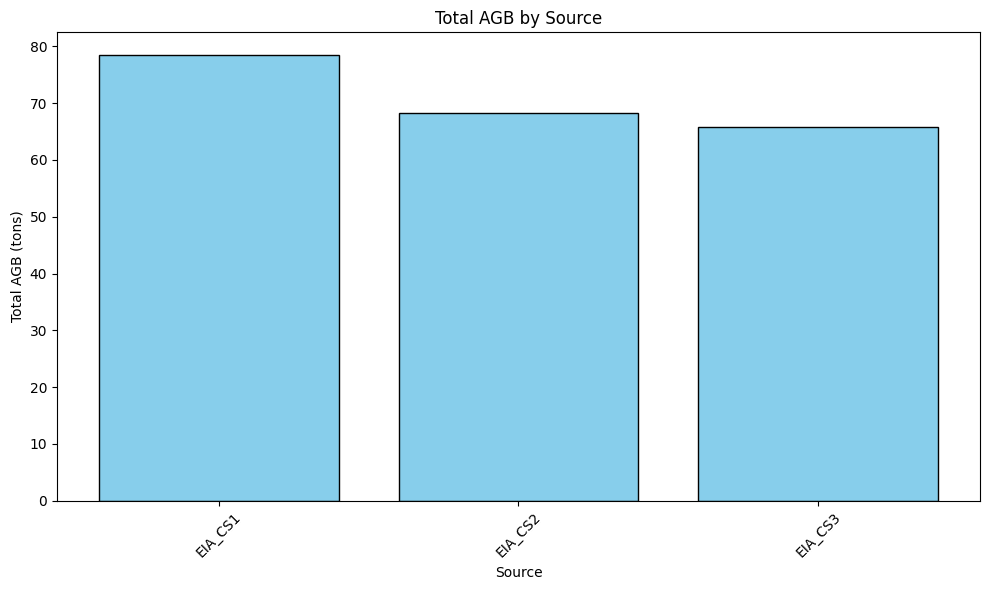

In [83]:
import matplotlib.pyplot as plt

# Aggregate total AGB by Source
agg = gdf.groupby("Source")["agb_per_acre"].sum().reset_index()

# Bar chart
plt.figure(figsize=(10,6))
plt.bar(agg["Source"], agg["agb_per_acre"], color="skyblue", edgecolor="black")

plt.xlabel("Source")
plt.ylabel("Total AGB (tons)")
plt.title("Total AGB by Source")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# OBIWAN approach

In [60]:
import ee, json


# Your FeatureCollections
EIA_CS1 = ee.FeatureCollection('projects/servir-sco-assets/assets/Rx_Fire/Vector_Data/EIA_CS1')
EIA_CS2 = ee.FeatureCollection('projects/servir-sco-assets/assets/Rx_Fire/Vector_Data/EIA_CS2')
EIA_CS3 = ee.FeatureCollection('projects/servir-sco-assets/assets/Rx_Fire/Vector_Data/EIA_CS3')

# Convert to GeoJSON (Python dicts)
geojson_fc1 = EIA_CS1.getInfo()
geojson_fc2 = EIA_CS2.getInfo()
geojson_fc3 = EIA_CS3.getInfo()


In [61]:
# EIA_CS1 = ee.FeatureCollection('projects/servir-sco-assets/assets/Rx_Fire/Vector_Data/EIA_CS1')
# EIA_CS2 = ee.FeatureCollection('projects/servir-sco-assets/assets/Rx_Fire/Vector_Data/EIA_CS2')
# EIA_CS3 = ee.FeatureCollection('projects/servir-sco-assets/assets/Rx_Fire/Vector_Data/EIA_CS3')

# geojson_fc1 = EIA_CS1.getInfo()
# geojson_fc2 = EIA_CS2.getInfo()
# geojson_fc3 = EIA_CS3.getInfo()


# import json

# with open("EIA_CS1.json", "w") as f:
#     json.dump(geojson_fc1, f)

# with open("EIA_CS2.json", "w") as f:
#     json.dump(geojson_fc2, f)

# with open("EIA_CS3.json", "w") as f:
#     json.dump(geojson_fc3, f)


In [62]:
# import json

# # Load the saved file
# with open("/content/EIA_CS1.json", "r") as f:
#     EIA_CS1_json = json.load(f)

# # Now "data" is a Python dict
# print(type(EIA_CS1_json))
# print(EIA_CS1_json.keys())   # Should show something like: ['type', 'features']



# with open("/content/EIA_CS2.json", "r") as f:
#     EIA_CS2_json = json.load(f)


# with open("/content/EIA_CS3.json", "r") as f:
#     EIA_CS3_json = json.load(f)

In [63]:
import requests

class ObiwanClient:
    def __init__(self, base_url="https://obiwan-alabama-api-5026633953.us-west1.run.app"):
        self.base_url = base_url.rstrip('/')

    def estimate_biomass_stock(self, year, geojson_payload, calibration_flag=False):
        # New endpoint (shorter path)
        endpoint = f"{self.base_url}/estimate_biomass_state_geojson/{year}"
        params = {"use_calibration": str(calibration_flag).lower()}  # true/false
        headers = {"Content-Type": "application/json"}

        response = requests.post(endpoint, params=params, json=geojson_payload, headers=headers)
        response.raise_for_status()
        return response.json()


In [64]:
client = ObiwanClient()

year = 2019
calibration_flag = True  # or True

In [65]:
# estimates_fc1 = client.estimate_biomass_stock(year, geojson_fc1, calibration_flag)
# # estimates_fc2 = client.estimate_biomass_stock(year, geojson_fc2, calibration_flag)
# # estimates_fc3 = client.estimate_biomass_stock(year, geojson_fc3, calibration_flag)
# print(estimates_fc1)
# # pd.DataFrame([estimates_fc1])
# # pd.DataFrame([estimates_fc2])
# # pd.DataFrame([estimates_fc3])

In [66]:
estimates_fc1 = client.estimate_biomass_stock(year, geojson_fc1, calibration_flag)
print(estimates_fc1)

{'AGBD': 201.2545406801871, 'area': 5152478.115234375, 'asset_version': '1.0', 'stdAGBD': 2.620773988024994, 'use_calibration': True, 'year': 2019}


In [67]:
estimates_fc2 = client.estimate_biomass_stock(year, geojson_fc2, calibration_flag)
print(estimates_fc2)

{'AGBD': 198.77709747704773, 'area': 10821259.333984375, 'asset_version': '1.0', 'stdAGBD': 3.0370967908580146, 'use_calibration': True, 'year': 2019}


In [68]:
estimates_fc3 = client.estimate_biomass_stock(year, geojson_fc3, calibration_flag)
print(estimates_fc2)

{'AGBD': 198.77709747704773, 'area': 10821259.333984375, 'asset_version': '1.0', 'stdAGBD': 3.0370967908580146, 'use_calibration': True, 'year': 2019}


In [69]:
df1 = pd.DataFrame([estimates_fc1])#.insert(1,"Source",["EIA_CS1"])
df1["Source"] = "EIA_CS1"
df1["Method"] = "OBIWAN"
df2 = pd.DataFrame([estimates_fc2])#.insert(1,"Source",["EIA_CS2"])
df2["Source"] = "EIA_CS2"
df2["Method"] = "OBIWAN"
df3 = pd.DataFrame([estimates_fc3])#.insert(1,"Source",["EIA_CS3"])
df3["Source"] = "EIA_CS3"
df3["Method"] = "OBIWAN"

In [70]:
combined_df_append = pd.concat([df1, df2, df3], ignore_index=True)
print(combined_df_append)

         AGBD          area asset_version   stdAGBD  use_calibration  year  \
0  201.254541  5.152478e+06           1.0  2.620774             True  2019   
1  198.777097  1.082126e+07           1.0  3.037097             True  2019   
2  170.233926  4.160505e+06           1.0  2.867049             True  2019   

    Source  Method  
0  EIA_CS1  OBIWAN  
1  EIA_CS2  OBIWAN  
2  EIA_CS3  OBIWAN  


In [84]:

# Convert area from square meters to acres
combined_df_append['area_acres'] = combined_df_append['area'].divide(4046.86)

# Calculate agb_per_acre
combined_df_append['agb_per_acre'] = combined_df_append['AGBD'] / combined_df_append['area_acres']

# Optional: drop the temporary area_acres column if you don't need it
# combined_df_append = combined_df_append.drop(columns=['area_acres'])

# Check the result
print(combined_df_append)


         AGBD          area asset_version   stdAGBD  use_calibration  year  \
0  201.254541  5.152478e+06           1.0  2.620774             True  2019   
1  198.777097  1.082126e+07           1.0  3.037097             True  2019   
2  170.233926  4.160505e+06           1.0  2.867049             True  2019   

    Source  Method   area_acres  agb_per_acre  
0  EIA_CS1  OBIWAN  1273.203945      0.158069  
1  EIA_CS2  OBIWAN  2673.989052      0.074337  
2  EIA_CS3  OBIWAN  1028.082356      0.165584  


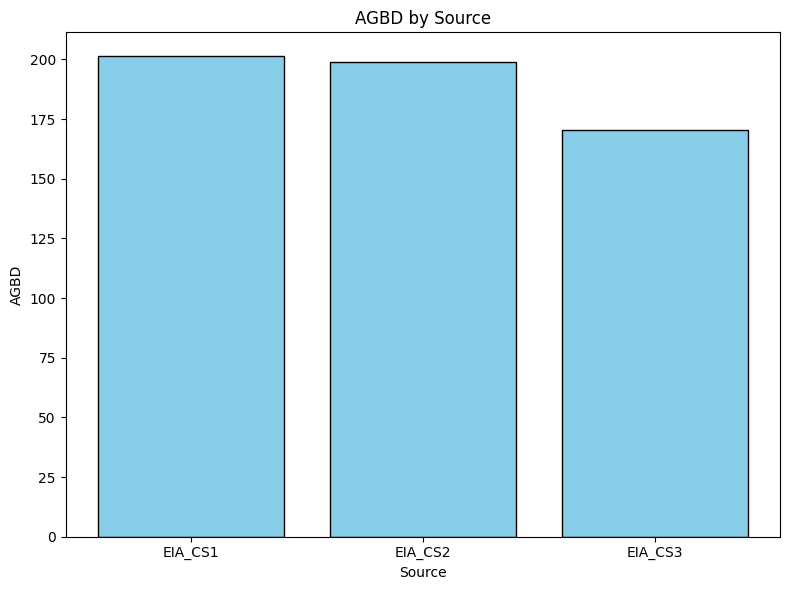

In [88]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.bar(combined_df_append["Source"], combined_df_append["AGBD"], color="skyblue", edgecolor="black")

plt.xlabel("Source")
plt.ylabel("AGBD")
plt.title("AGBD by Source")
plt.tight_layout()
plt.show()


Cross compare

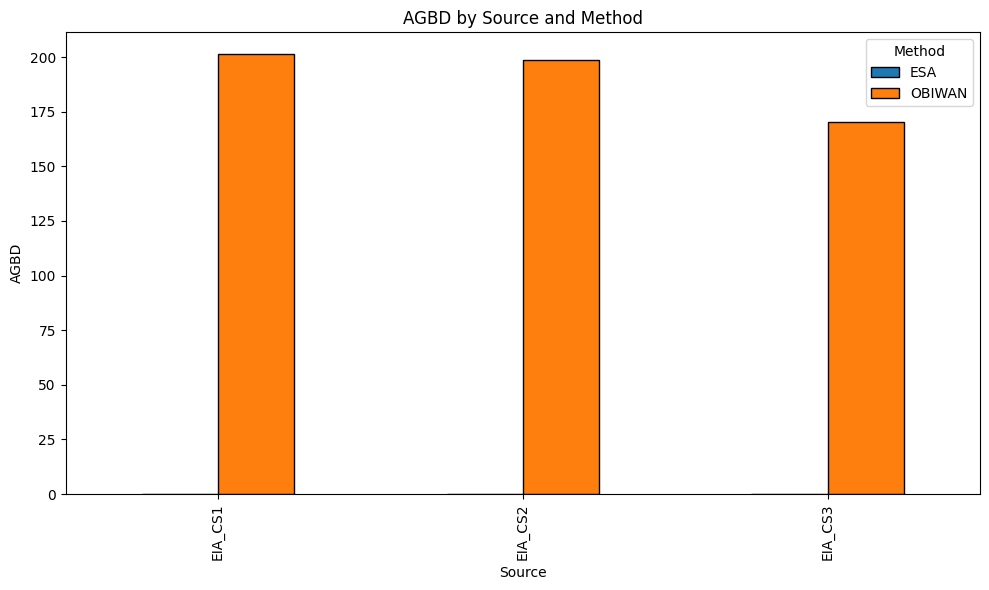

In [72]:
import pandas as pd
import matplotlib.pyplot as plt

# Suppose you already have df_esa and df_obiwan
# Concatenate them into one DataFrame
df_all = pd.concat([gdf, combined_df_append], ignore_index=True)

# Pivot for plotting grouped bars
pivot_df = df_all.pivot(index="Source", columns="Method", values="AGBD")

# Plot
pivot_df.plot(kind="bar", figsize=(10,6), edgecolor="black")

plt.xlabel("Source")
plt.ylabel("AGBD")
plt.title("AGBD by Source and Method")
plt.legend(title="Method")
plt.tight_layout()
plt.show()


In [73]:
!pip install brokenaxes


ValueError: invalid __array_struct__

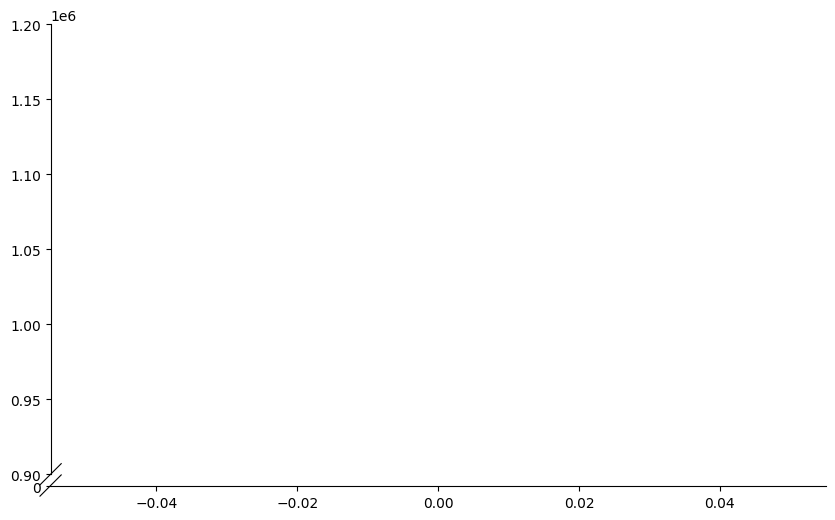

In [74]:
import pandas as pd
import matplotlib.pyplot as plt
from brokenaxes import brokenaxes

# Combine ESA and OBIWAN into one DataFrame
df_all = pd.concat([gdf, combined_df_append], ignore_index=True)

# Pivot for grouped bar chart
pivot_df = df_all.pivot(index="Source", columns="Method", values="AGBD")

# Create broken axis (adjust ranges depending on your data)
fig = plt.figure(figsize=(10,6))
bax = brokenaxes(ylims=((0, 500), (9e5, 1.2e6)), hspace=.05)

# Plot bars
pivot_df.plot(kind="bar", ax=bax, edgecolor="black")

# Labels
bax.set_xlabel("Source")
bax.set_ylabel("AGBD")
fig.suptitle("AGBD by Source (ESA vs OBIWAN with Broken Y-axis)")

plt.tight_layout()
plt.show()
